### About the dataset

This data was extracted from the 1994 Census bureau database by Ronny Kohavi and Barry Becker (Data Mining and Visualization, Silicon Graphics). A set of reasonably clean records was extracted using the following conditions: ((AAGE>16) && (AGI>100) && (AFNLWGT>1) && (HRSWK>0)). The prediction task is to determine whether a person makes over $50K a year.

### Importing libraries

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
from sklearn.preprocessing import StandardScaler
from imblearn.over_sampling import SMOTE
from sklearn.model_selection import train_test_split,GridSearchCV,cross_val_score,RandomizedSearchCV
import statsmodels.api as sm
import pickle
import warnings
warnings.filterwarnings('ignore')

### Importing Dataset

In [2]:
df = pd.read_csv("census_income.csv")
df.head(5)

,Age,Workclass,Fnlwgt,Education,Education_num,Marital_status,Occupation,Relationship,Race,Sex,Capital_gain,Capital_loss,Hours_per_week,Native_country,Income
0,50,Self-emp-not-inc,83311,Bachelors,13,Married-civ-spouse,Exec-managerial,Husband,White,Male,0,0,13,United-States,<=50K
1,38,Private,215646,HS-grad,9,Divorced,Handlers-cleaners,Not-in-family,White,Male,0,0,40,United-States,<=50K
2,53,Private,234721,11th,7,Married-civ-spouse,Handlers-cleaners,Husband,Black,Male,0,0,40,United-States,<=50K
3,28,Private,338409,Bachelors,13,Married-civ-spouse,Prof-specialty,Wife,Black,Female,0,0,40,Cuba,<=50K
4,37,Private,284582,Masters,14,Married-civ-spouse,Exec-managerial,Wife,White,Female,0,0,40,United-States,<=50K


In [3]:
df["Income"].value_counts()

 <=50K    24719
 >50K      7841
Name: Income, dtype: int64

#### The problem is a classification type and the two classes are Income >50k and Income<=50K

#### Checking for null values

In [4]:
df.isnull().sum()

Age               0
Workclass         0
Fnlwgt            0
Education         0
Education_num     0
Marital_status    0
Occupation        0
Relationship      0
Race              0
Sex               0
Capital_gain      0
Capital_loss      0
Hours_per_week    0
Native_country    0
Income            0
dtype: int64

#### Dataset doesn't have any null value

In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 32560 entries, 0 to 32559
Data columns (total 15 columns):
 #   Column          Non-Null Count  Dtype 
---  ------          --------------  ----- 
 0   Age             32560 non-null  int64 
 1   Workclass       32560 non-null  object
 2   Fnlwgt          32560 non-null  int64 
 3   Education       32560 non-null  object
 4   Education_num   32560 non-null  int64 
 5   Marital_status  32560 non-null  object
 6   Occupation      32560 non-null  object
 7   Relationship    32560 non-null  object
 8   Race            32560 non-null  object
 9   Sex             32560 non-null  object
 10  Capital_gain    32560 non-null  int64 
 11  Capital_loss    32560 non-null  int64 
 12  Hours_per_week  32560 non-null  int64 
 13  Native_country  32560 non-null  object
 14  Income          32560 non-null  object
dtypes: int64(6), object(9)
memory usage: 3.7+ MB


#### Most of the columns are of object datatype, lets convert that to numerical values by encoding techniques

In [6]:
from sklearn.preprocessing import LabelEncoder
label_enc = LabelEncoder()
for column in df:
    df[column] = label_enc.fit_transform(df[column])
df.head(5)

,Age,Workclass,Fnlwgt,Education,Education_num,Marital_status,Occupation,Relationship,Race,Sex,Capital_gain,Capital_loss,Hours_per_week,Native_country,Income
0,33,6,2925,9,12,2,4,0,4,1,0,0,12,39,0
1,21,4,14085,11,8,0,6,1,4,1,0,0,39,39,0
2,36,4,15335,1,6,2,6,0,2,1,0,0,39,39,0
3,11,4,19354,9,12,2,10,5,2,0,0,0,39,5,0
4,20,4,17699,12,13,2,4,5,4,0,0,0,39,39,0


#### if income <= 50K,is class 0 and income > 50K is class 1

### EDA

#### Plotting the relationship between features and target variable

In [7]:
df.shape

(32560, 15)

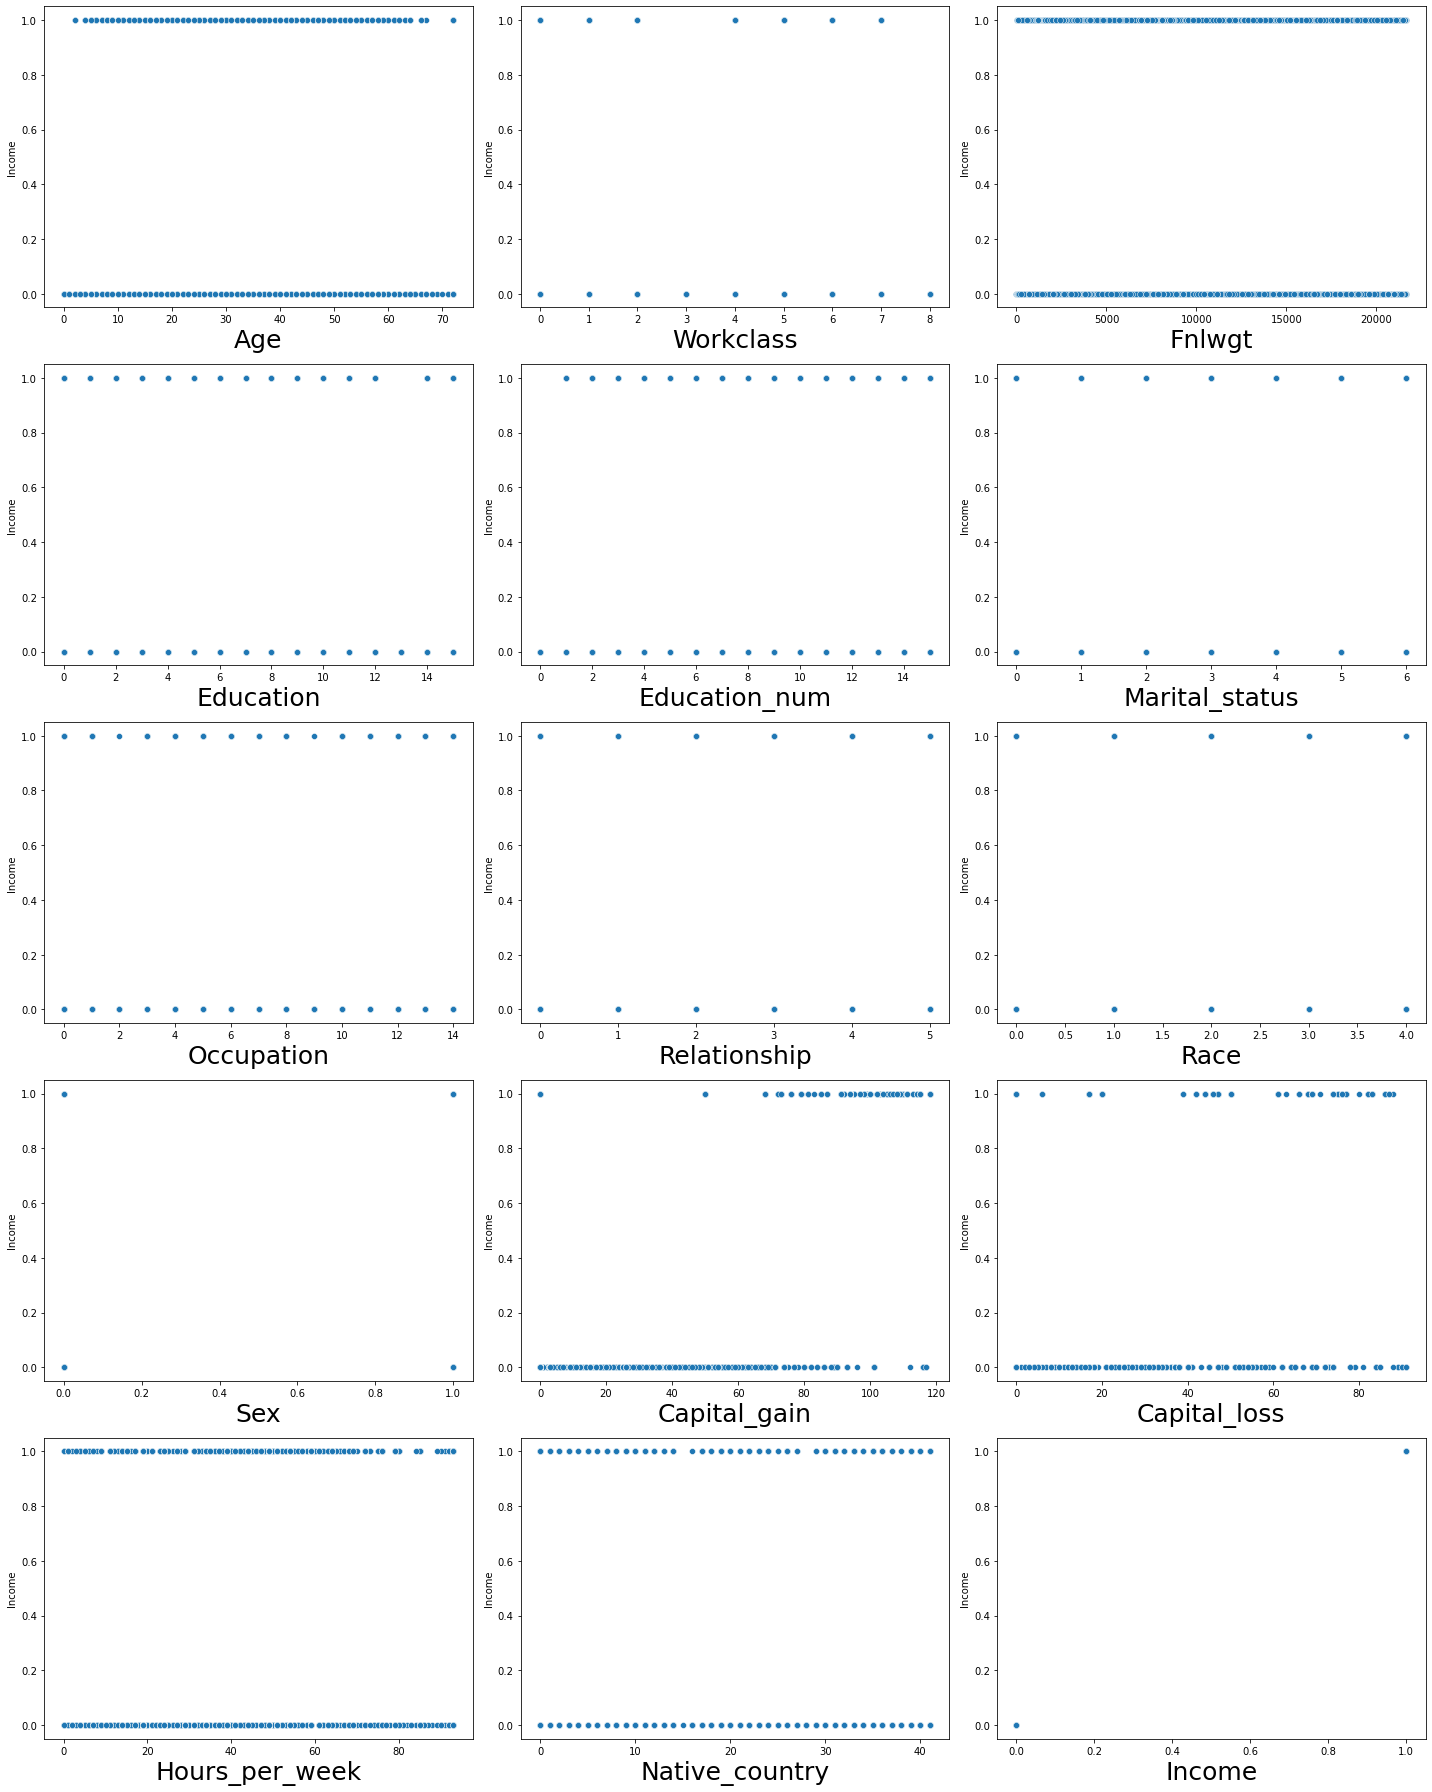

In [8]:
plt.figure(figsize=(20,25),facecolor="white")
plotnumber=1
for column in df:
    if plotnumber<=15:
        ax=plt.subplot(5,3,plotnumber)
        sns.scatterplot(x=df[column],y=df['Income'],data=df)
        plt.xlabel(column,fontsize=25)
    plotnumber+=1
plt.tight_layout()

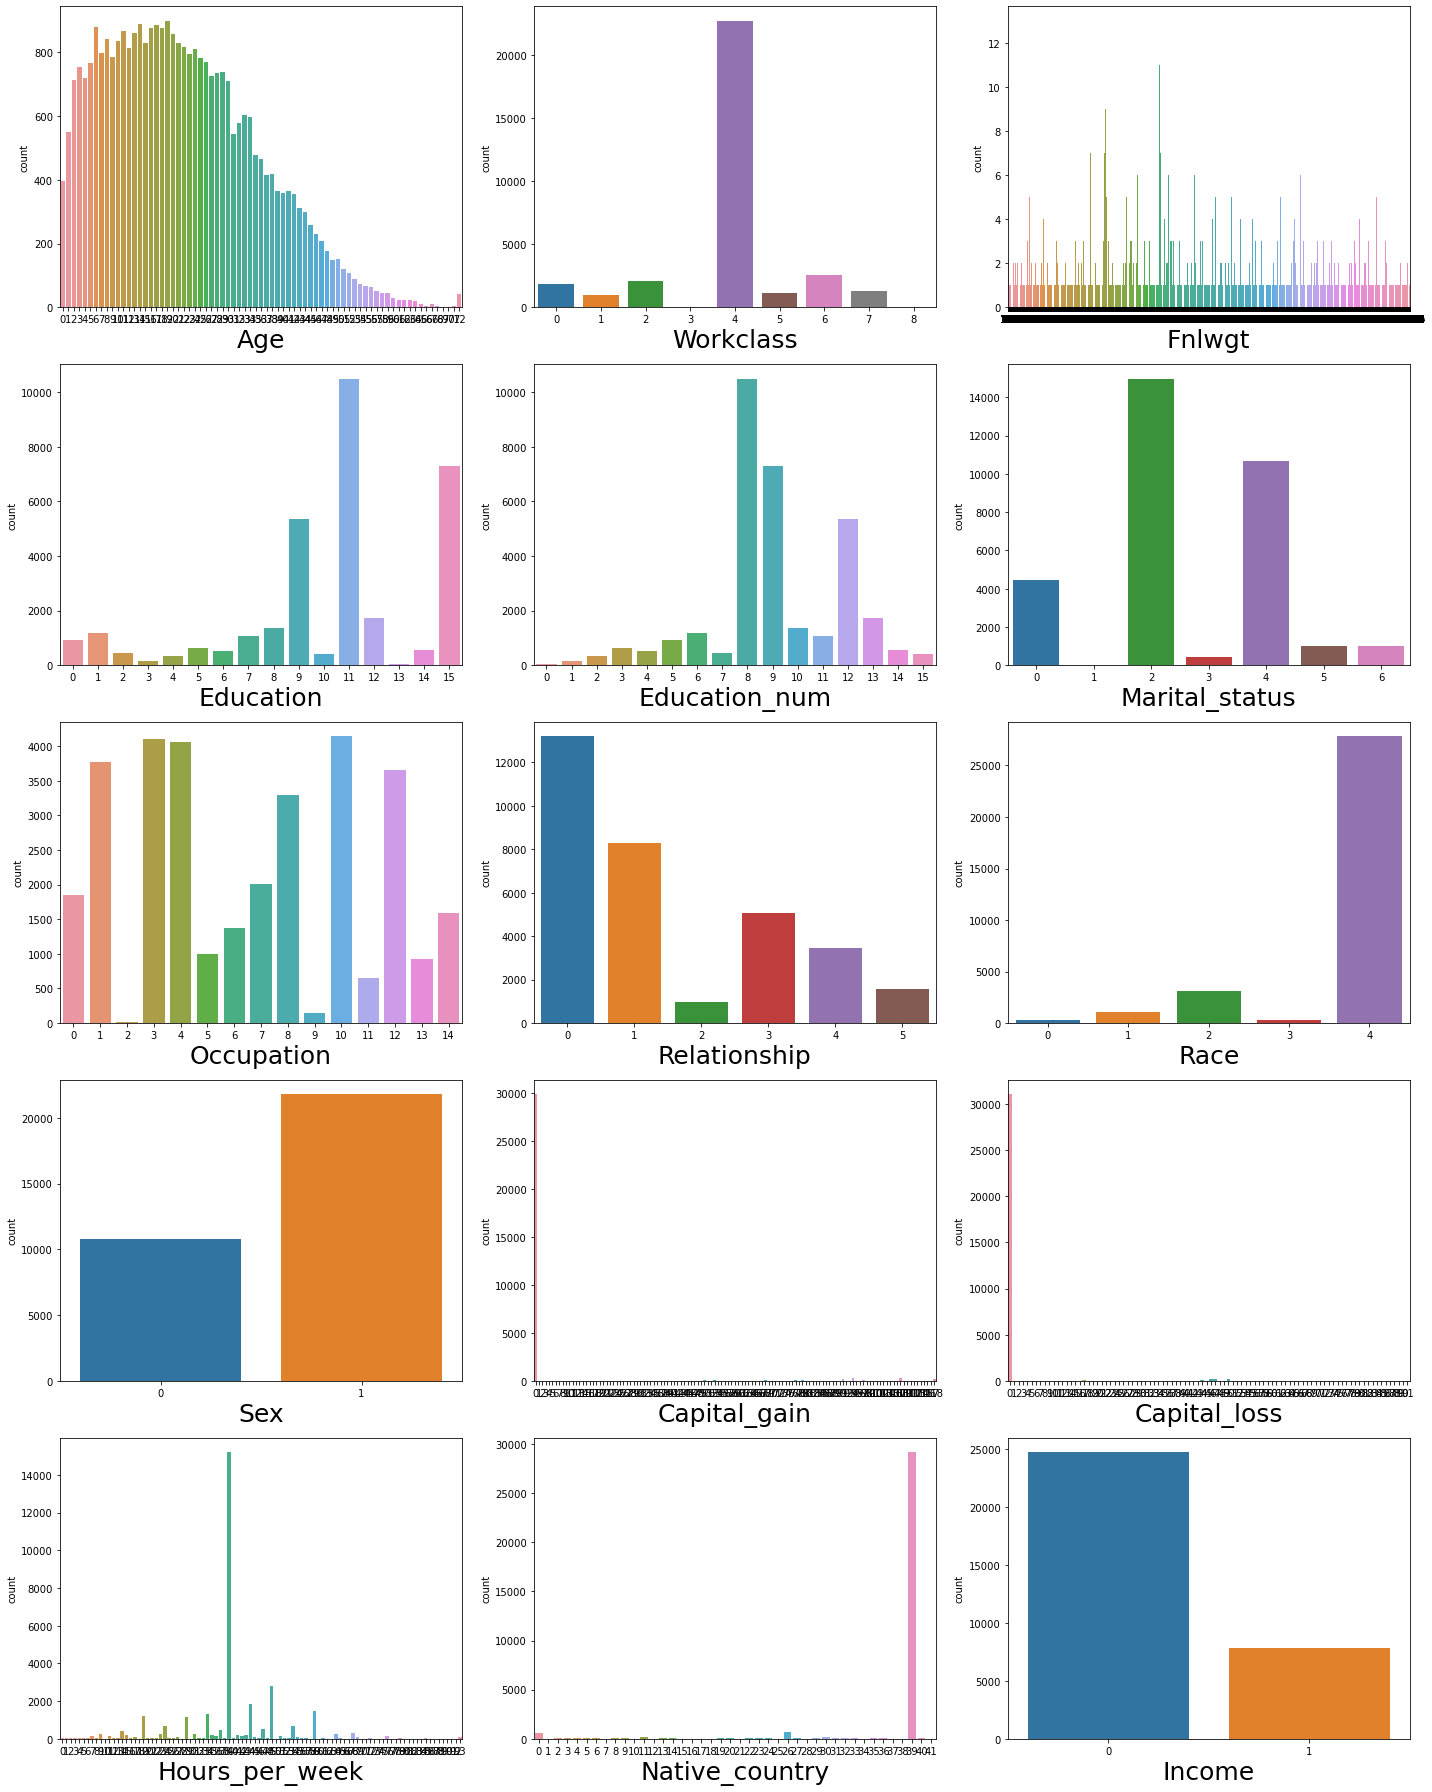

In [9]:
plt.figure(figsize=(20,25),facecolor="white")
plotnumber=1
for column in df:
    if plotnumber<=15:
        ax=plt.subplot(5,3,plotnumber)
        sns.countplot(df[column])
        plt.xlabel(column,fontsize=25)
    plotnumber+=1
plt.tight_layout()

#### Checking correlation

In [10]:
df.corr()

,Age,Workclass,Fnlwgt,Education,Education_num,Marital_status,Occupation,Relationship,Race,Sex,Capital_gain,Capital_loss,Hours_per_week,Native_country,Income
Age,1.000000,0.003829,-0.078466,-0.010499,0.036547,-0.266433,-0.020929,-0.263783,0.028751,0.088863,0.125916,0.065058,0.069123,-0.001145,0.234136
Workclass,0.003829,1.000000,-0.018359,0.023537,0.052015,-0.064798,0.255004,-0.090449,0.049720,0.095942,0.029297,0.015630,0.139553,-0.007710,0.051645
Fnlwgt,-0.078466,-0.018359,1.000000,-0.027082,-0.042806,0.030163,0.003417,0.007005,-0.008964,0.025787,-0.004562,-0.009912,-0.019168,-0.057038,-0.010573
Education,-0.010499,0.023537,-0.027082,1.000000,0.359172,-0.038398,-0.021274,-0.010879,0.014135,-0.027349,0.031392,0.016111,0.056295,0.064291,0.079311
Education_num,0.036547,0.052015,-0.042806,0.359172,1.000000,-0.069338,0.109748,-0.094145,0.031825,0.012256,0.154387,0.084175,0.150098,0.050831,0.335182
Marital_status,-0.266433,-0.064798,0.030163,-0.038398,-0.069338,1.000000,-0.009617,0.185461,-0.068025,-0.129337,-0.075162,-0.035235,-0.192647,-0.023827,-0.199295
Occupation,-0.020929,0.255004,0.003417,-0.021274,0.109748,-0.009617,1.000000,-0.075620,0.006779,0.080328,0.026285,0.017334,0.080622,-0.012532,0.075448
Relationship,-0.263783,-0.090449,0.007005,-0.010879,-0.094145,0.185461,-0.075620,1.000000,-0.116052,-0.582453,-0.093141,-0.064286,-0.251353,-0.005504,-0.250924
Race,0.028751,0.049720,-0.008964,0.014135,0.031825,-0.068025,0.006779,-0.116052,1.000000,0.087197,0.024951,0.019366,0.042318,0.137849,0.071853
Sex,0.088863,0.095942,0.025787,-0.027349,0.012256,-0.129337,0.080328,-0.582453,0.087197,1.000000,0.077573,0.049549,0.231357,-0.008125,0.215995


#### It is clear that Age,Education_num,Relationship,Sex,Capital_gain,Hours_per_week have high correlation with Income
#### Relationship and Sex are correlated

#### Statistical Analysis

In [11]:
df.describe()

,Age,Workclass,Fnlwgt,Education,Education_num,Marital_status,Occupation,Relationship,Race,Sex,Capital_gain,Capital_loss,Hours_per_week,Native_country,Income
count,32560.000000,32560.000000,32560.000000,32560.000000,32560.000000,32560.000000,32560.000000,32560.000000,32560.000000,32560.000000,32560.000000,32560.000000,32560.000000,32560.000000,32560.000000
mean,21.580313,3.868796,10498.253256,10.298249,9.080590,2.611794,6.572912,1.446376,3.665848,0.669195,6.500645,2.053348,39.377948,36.718796,0.240817
std,13.635711,1.455879,6048.727241,3.870317,2.572709,1.506225,4.228809,1.606794,0.848817,0.470510,23.300419,10.056712,12.144192,7.823892,0.427586
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,11.000000,4.000000,5395.750000,9.000000,8.000000,2.000000,3.000000,0.000000,4.000000,0.000000,0.000000,0.000000,39.000000,39.000000,0.000000
50%,20.000000,4.000000,10347.500000,11.000000,9.000000,2.000000,7.000000,1.000000,4.000000,1.000000,0.000000,0.000000,39.000000,39.000000,0.000000
75%,31.000000,4.000000,15486.250000,12.000000,11.000000,4.000000,10.000000,3.000000,4.000000,1.000000,0.000000,0.000000,44.000000,39.000000,0.000000
max,72.000000,8.000000,21646.000000,15.000000,15.000000,6.000000,14.000000,5.000000,4.000000,1.000000,118.000000,91.000000,93.000000,41.000000,1.000000


#### Checking for outliers

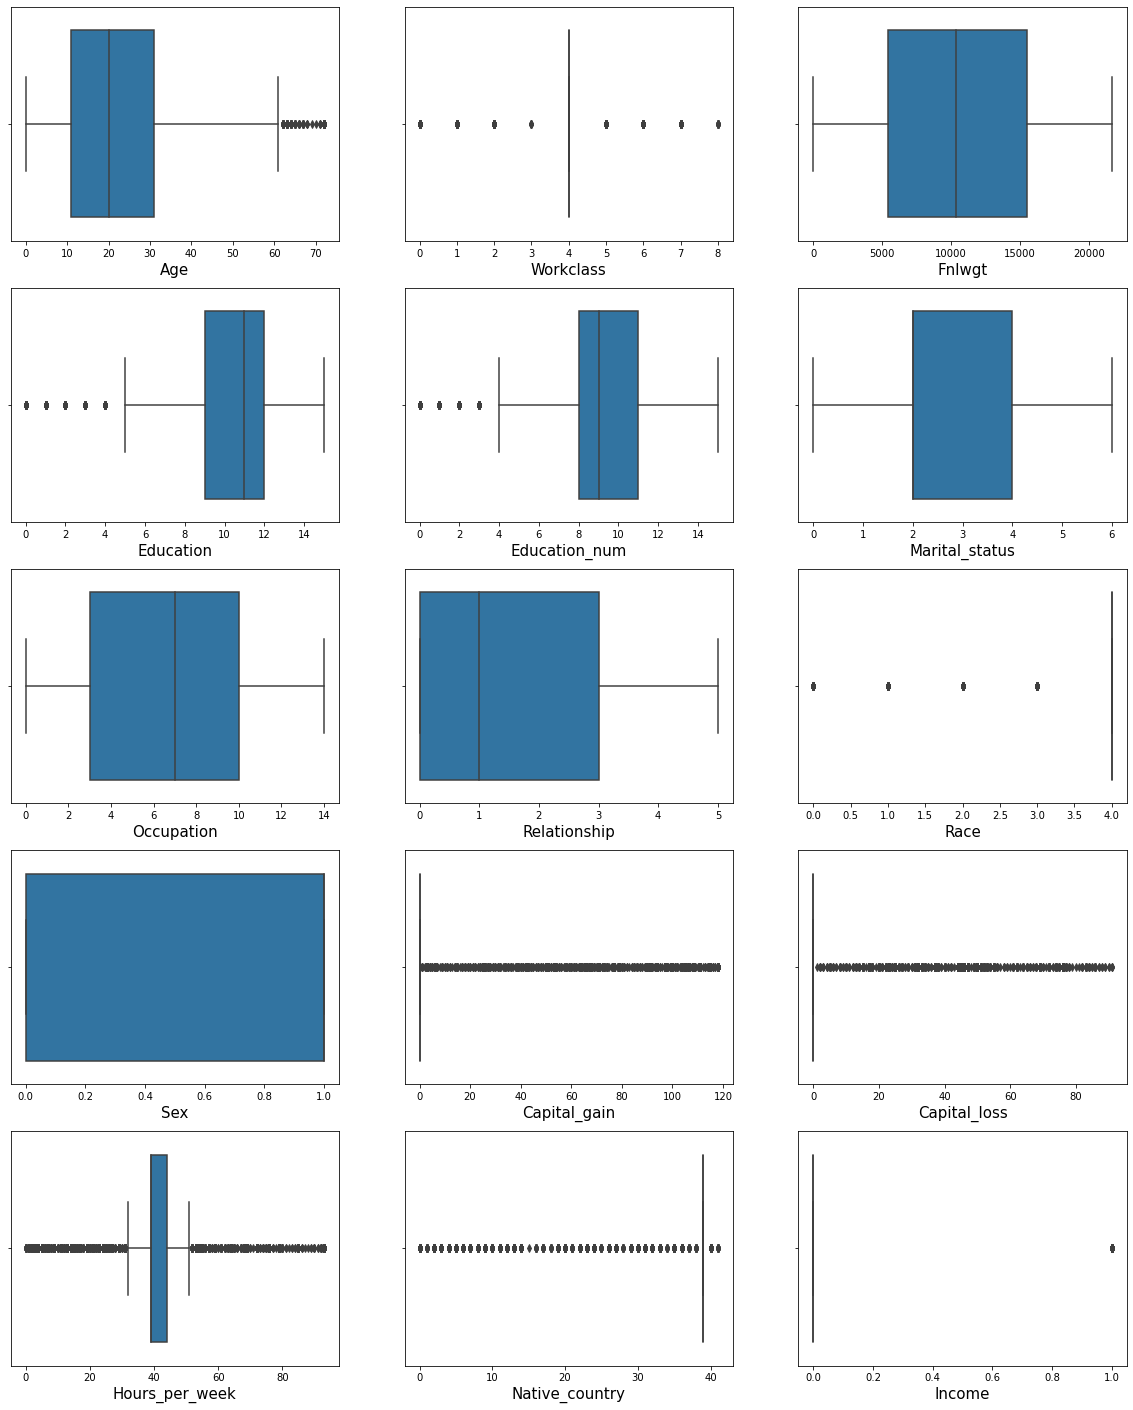

In [12]:
plt.figure(figsize=(20,25))
gr = 1
for column in df:
    if gr<=15:
        ax = plt.subplot(5,3,gr)
        sns.boxplot(df[column],orient='v')
        plt.xlabel(column,fontsize=15)
    gr+=1
plt.show()

##### Almost all the columns have outliers

#### Checking for Skewness

In [13]:
df.skew()

Age               0.555583
Workclass        -0.752280
Fnlwgt            0.063137
Education        -0.934063
Education_num    -0.311630
Marital_status   -0.013448
Occupation        0.114540
Relationship      0.786784
Race             -2.435332
Sex              -0.719244
Capital_gain      3.572186
Capital_loss      5.266058
Hours_per_week    0.069753
Native_country   -3.658235
Income            1.212383
dtype: float64

#### The columns are skewed except Fnlwgt,Education_num,Maritul_status,Occupation,Hours_per_week
#### Income is skewed because it is imbalanced

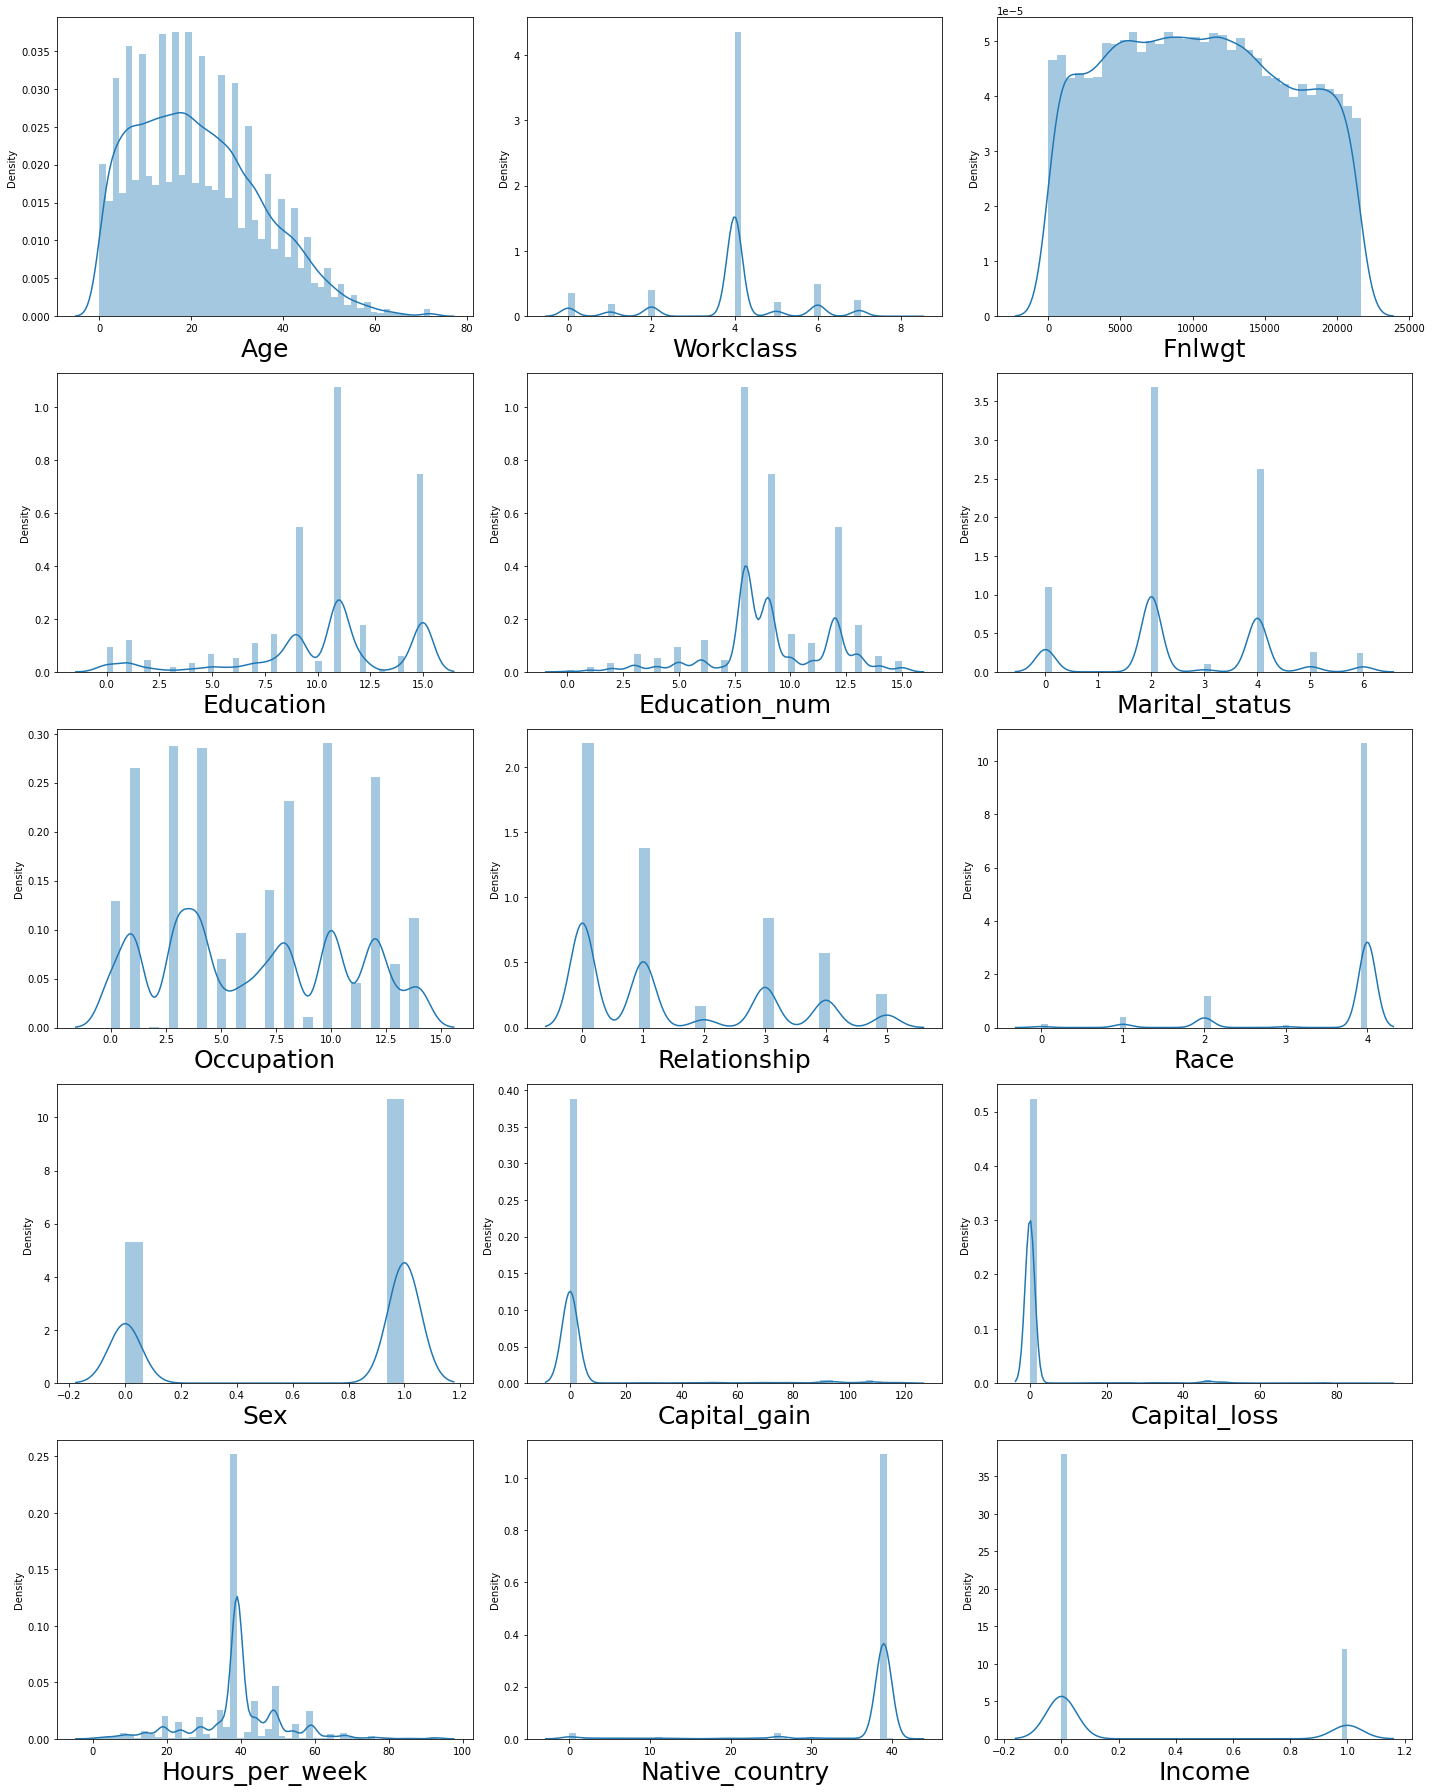

In [14]:
plt.figure(figsize=(20,25),facecolor="white")
plotnumber=1
for column in df:
    if plotnumber<=15:
        ax=plt.subplot(5,3,plotnumber)
        sns.distplot(df[column])
        plt.xlabel(column,fontsize=25)
    plotnumber+=1
plt.tight_layout()

#### Data cleaning

In [15]:
df = df.drop(columns=['Native_country','Education','Workclass','Race','Capital_loss'])
df.head(3)

,Age,Fnlwgt,Education_num,Marital_status,Occupation,Relationship,Sex,Capital_gain,Hours_per_week,Income
0,33,2925,12,2,4,0,1,0,12,0
1,21,14085,8,0,6,1,1,0,39,0
2,36,15335,6,2,6,0,1,0,39,0


In [16]:
df.shape

(32560, 10)

#### Removing Outliers from the datset

In [17]:
from scipy.stats import zscore
z = np.abs(zscore(df))
print("Old shape : ",z.shape)
print(z)
print("Row numbers : ",np.where(z>3)[0])
print("Column numbers : ",np.where(z>3)[0])
index = np.where(z>3)[0]
df1 = df.drop(df.index[index])
print("New shape : ",df1.shape)

Old shape :  (32560, 10)
[[0.83749664 1.25206002 1.13477863 ... 0.2789969  2.25444135 0.5632099 ]
 [0.042559   0.59298455 0.42002663 ... 0.2789969  0.03112222 0.5632099 ]
 [1.05751055 0.79964277 1.19742926 ... 0.2789969  0.03112222 0.5632099 ]
 ...
 [1.42420039 0.43253619 0.42002663 ... 0.2789969  0.03112222 0.5632099 ]
 [1.21596651 0.39376603 0.42002663 ... 0.2789969  1.67802528 0.5632099 ]
 [0.98417258 1.21114062 0.42002663 ... 4.35618396 0.03112222 1.77553698]]
Row numbers :  [    7     8     9 ... 32530 32537 32559]
Column numbers :  [    7     8     9 ... 32530 32537 32559]
New shape :  (30188, 10)


#### Data Loss

In [18]:
loss = (32560-27893)/32560*100
print("While removing outliers we loss ",loss,"% of data")

While removing outliers we loss  14.333538083538084 % of data


#### While removing outliers we loss too much of data

#### Splitting dataset into x and y

In [19]:
x = df.drop("Income",axis=1)
y = df["Income"]

#### Removing skewness

In [20]:
from sklearn.preprocessing import power_transform
x_new = power_transform(x,method='yeo-johnson')
x_new

array([[ 0.87362203, -1.27716676,  1.16503904, ...,  0.70308748,
        -0.30136168, -2.21146233],
       [ 0.11433958,  0.63481858, -0.46398181, ...,  0.70308748,
        -0.30136168, -0.04137831],
       [ 1.04248272,  0.81014526, -1.20230141, ...,  0.70308748,
        -0.30136168, -0.04137831],
       ...,
       [ 1.31017929, -0.32089959, -0.46398181, ..., -1.42229812,
        -0.30136168, -0.04137831],
       [-1.34329839,  0.46127357, -0.46398181, ...,  0.70308748,
        -0.30136168, -1.66383835],
       [ 0.98693797,  1.14689558, -0.46398181, ..., -1.42229812,
         3.32061235, -0.04137831]])

In [21]:
x_new = pd.DataFrame(x_new,columns=x.columns)
x_new.skew()

Age              -0.104049
Fnlwgt           -0.263791
Education_num     0.019545
Marital_status   -0.114201
Occupation       -0.187152
Relationship      0.122917
Sex              -0.719244
Capital_gain      3.017222
Hours_per_week    0.199586
dtype: float64

#### making the class balanced

In [22]:
from imblearn.over_sampling import SMOTE
sm = SMOTE()
x_over,y_over = sm.fit_resample(x,y)

In [23]:
y_over.value_counts()

1    24719
0    24719
Name: Income, dtype: int64

#### Scale the data

In [24]:
scale = StandardScaler()
X_scaled = scale.fit_transform(x_over)

#### finding the best random state

In [25]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import confusion_matrix,classification_report,accuracy_score
max_accuracy = 0
max_rs = 0
for i in range(1,300):
    x_train,x_test,y_train,y_test = train_test_split(X_scaled,y_over,test_size=0.25,random_state = i)
    LR = LogisticRegression()
    LR.fit(x_train,y_train)
    y_pred = LR.predict(x_test)
    accu_score = accuracy_score(y_test,y_pred)
    if accu_score>max_accuracy:
        max_accuracy = accu_score
        max_rs = i
print("Maximum accuracy is",max_accuracy,"when",max_rs,"is the random state")

Maximum accuracy is 0.7758899676375405 when 267 is the random state


#### Splitting into train and test dataset

In [26]:
x_train,x_test,y_train,y_test = train_test_split(X_scaled,y_over,test_size=0.25,random_state = 58)

### MODEL TRAINING

#### Logistic Regression

In [27]:
lr = LogisticRegression()
lr.fit(x_train,y_train)
y_pred_lr = lr.predict(x_test)
lr_accuracy = accuracy_score(y_test,y_pred_lr)
print("Accuracy of Logistic Regression model is ",lr_accuracy)
print("Confusion Matrix","\n",confusion_matrix(y_test,y_pred_lr))
classification_rep = classification_report(y_test,y_pred_lr)
print("Classification report ; \n",classification_rep)

Accuracy of Logistic Regression model is  0.768042071197411
Confusion Matrix 
 [[4654 1478]
 [1389 4839]]
Classification report ; 
               precision    recall  f1-score   support

           0       0.77      0.76      0.76      6132
           1       0.77      0.78      0.77      6228

    accuracy                           0.77     12360
   macro avg       0.77      0.77      0.77     12360
weighted avg       0.77      0.77      0.77     12360



#### Logistic Regression works with an accuracy of 76.80%

#### Decision tree Classifier

In [28]:
from sklearn.tree import DecisionTreeClassifier
dt = DecisionTreeClassifier()
dt.fit(x_train,y_train)
y_pred_dt = dt.predict(x_test)
dt_accuracy = accuracy_score(y_test,y_pred_dt)
conf_mat = confusion_matrix(y_test,y_pred_dt)
classification_rep = classification_report(y_test,y_pred_dt)
print("Accuracy of Decision Tree classifier model is ",dt_accuracy)
print("Confusion Matrix","\n",conf_mat)
print("Classification report ; \n",classification_rep)

Accuracy of Decision Tree classifier model is  0.8311488673139159
Confusion Matrix 
 [[5036 1096]
 [ 991 5237]]
Classification report ; 
               precision    recall  f1-score   support

           0       0.84      0.82      0.83      6132
           1       0.83      0.84      0.83      6228

    accuracy                           0.83     12360
   macro avg       0.83      0.83      0.83     12360
weighted avg       0.83      0.83      0.83     12360



#### Decision tree classifier works with an accuracy of 83.11%

#### Random Forest Classifier

In [29]:
from sklearn.ensemble import RandomForestClassifier
rf = RandomForestClassifier()
rf.fit(x_train,y_train)
y_pred_rf = rf.predict(x_test)
rf_accuracy = accuracy_score(y_test,y_pred_rf)
conf_mat = confusion_matrix(y_test,y_pred_rf)
classification_rep = classification_report(y_test,y_pred_rf)
print("Accuracy of Random forest classifier model is ",rf_accuracy)
print("Confusion Matrix","\n",conf_mat)
print("Classification report ; \n",classification_rep)

Accuracy of Random forest classifier model is  0.8676375404530744
Confusion Matrix 
 [[5228  904]
 [ 732 5496]]
Classification report ; 
               precision    recall  f1-score   support

           0       0.88      0.85      0.86      6132
           1       0.86      0.88      0.87      6228

    accuracy                           0.87     12360
   macro avg       0.87      0.87      0.87     12360
weighted avg       0.87      0.87      0.87     12360



#### Random forest classifier works with an accuracy of 86.76%

#### SVC

In [30]:
from sklearn.svm import SVC
svc = SVC()
svc.fit(x_train,y_train)
y_pred_svc = svc.predict(x_test)
svc_accuracy = accuracy_score(y_test,y_pred_svc)
conf_mat = confusion_matrix(y_test,y_pred_svc)
classification_rep = classification_report(y_test,y_pred_svc)
print("Accuracy of SVC model is ",svc_accuracy)
print("Confusion Matrix","\n",conf_mat)
print("Classification report ; \n",classification_rep)

Accuracy of SVC model is  0.837378640776699
Confusion Matrix 
 [[4827 1305]
 [ 705 5523]]
Classification report ; 
               precision    recall  f1-score   support

           0       0.87      0.79      0.83      6132
           1       0.81      0.89      0.85      6228

    accuracy                           0.84     12360
   macro avg       0.84      0.84      0.84     12360
weighted avg       0.84      0.84      0.84     12360



#### SVC works with an accuracy of 83.74%

### XGBoost Classifier

In [31]:
import xgboost as xgb
from xgboost import XGBClassifier
xgbc = XGBClassifier()
xgbc.fit(x_train,y_train)
y_pred_xgbc = xgbc.predict(x_test)
xgbc_accuracy = accuracy_score(y_test,y_pred_xgbc)
conf_mat = confusion_matrix(y_test,y_pred_xgbc)
classification_rep = classification_report(y_test,y_pred_xgbc)
print("Accuracy of Xgboost model is ",xgbc_accuracy)
print("Confusion Matrix","\n",conf_mat)
print("Classification report ; \n",classification_rep)

[14:27:38] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
Accuracy of Xgboost model is  0.8689320388349514
Confusion Matrix 
 [[5222  910]
 [ 710 5518]]
Classification report ; 
               precision    recall  f1-score   support

           0       0.88      0.85      0.87      6132
           1       0.86      0.89      0.87      6228

    accuracy                           0.87     12360
   macro avg       0.87      0.87      0.87     12360
weighted avg       0.87      0.87      0.87     12360



#### XGBoost works with an accyracy of 86.89%

### Cross-validating

In [32]:
cvs = cross_val_score(lr,X_scaled,y_over,cv=5)
print("Cross validation score of Logistic Regression model is : ",cvs.mean())

Cross validation score of Logistic Regression model is :  0.7639268004338998


In [33]:
cvs = cross_val_score(dt,X_scaled,y_over,cv=5)
print("Cross validation score of DecisionTreeClassifier is : ",cvs.mean())

Cross validation score of DecisionTreeClassifier is :  0.8302531121904053


In [34]:
cvs = cross_val_score(rf,X_scaled,y_over,cv=5)
print("Cross validation score of RandomForestClassifier is : ",cvs.mean())

Cross validation score of RandomForestClassifier is :  0.8668850997665203


In [35]:
cvs = cross_val_score(svc,X_scaled,y_over,cv=5)
print("Cross validation score of SVC is : ",cvs.mean())

Cross validation score of SVC is :  0.839719225713344


In [36]:
cvs = cross_val_score(xgbc,X_scaled,y_over,cv=5)
print("Cross validation score of XGBoostClassifier is : ",cvs.mean())

[14:33:09] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[14:33:12] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[14:33:14] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[14:33:16] WARNING: C:/Users/Administrator/workspace/xgboost-win64_rel

#### Finding the best model

In [37]:
models = pd.DataFrame([["Logistic Regression","76.80","76.39","0.41"],["DecisionTreeClassifier","83.11","83.03","0.08"],["RandomForestClassifier","86.76","86.67","0.09"],["SVC","83.74","83.97","0.23"],["XGBoostClassifier","86.89","86.94","0.05"]],columns=["Model","Accuracy","Cross Validation Score","Difference"])
models

,Model,Accuracy,Cross Validation Score,Difference
0,Logistic Regression,76.80,76.39,0.41
1,DecisionTreeClassifier,83.11,83.03,0.08
2,RandomForestClassifier,86.76,86.67,0.09
3,SVC,83.74,83.97,0.23
4,XGBoostClassifier,86.89,86.94,0.05


#### Boosting algorithm works best

#### Hyper parameter tuning

In [38]:
from sklearn.model_selection import GridSearchCV
params = {'learning_rate':[0.05,0.2,0.01],
          'n_estimators':[10,200,5],
          'max_depth':[2,12,1],
          'min_child_weight':[1,10,1],
          'max_leaf_nodes':[1,10,1]
         }
grid = GridSearchCV(estimator = xgbc,param_grid = params,cv=5,n_jobs=-1)
grid.fit(x_train,y_train)
best_params = grid.best_params_
print("Best Parameters are \n",best_params)

[14:56:43] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:573: 
Parameters: { "max_leaf_nodes" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[14:56:43] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
Best Parameters are 
 {'learning_rate': 0.2, 'max_depth': 12, 'max_leaf_nodes': 1, 'min_child_weight': 1, 'n_estimators': 200}


In [39]:
model = XGBClassifier(learning_rate=0.2,max_depth=12,min_child_weight=1,max_leaf_nodes=1,n_estimators=200)
model.fit(x_train,y_train)
y_pred = model.predict(x_test)
print("Accuracy Score after hyperparameter tuning is ",accuracy_score(y_test,y_pred))

[14:57:24] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:573: 
Parameters: { "max_leaf_nodes" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[14:57:24] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
Accuracy Score after hyperparameter tuning is  0.8806634304207119


#### After HPT accuracy increased by 88.07%

### Plotting ROC-AUC Curve

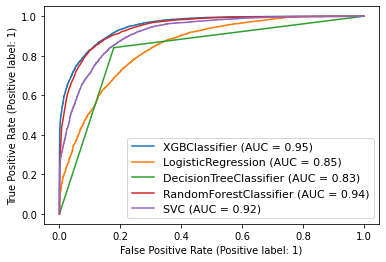

In [40]:
from sklearn.metrics import roc_curve,roc_auc_score,plot_roc_curve
disp = plot_roc_curve(xgbc,x_test,y_test)
plot_roc_curve(lr,x_test,y_test,ax=disp.ax_)
plot_roc_curve(dt,x_test,y_test,ax=disp.ax_)
plot_roc_curve(rf,x_test,y_test,ax=disp.ax_)
plot_roc_curve(svc,x_test,y_test,ax=disp.ax_)
plt.legend(prop={'size':11},loc='lower right')
plt.show()

#### From the curve it is clear that XGBoost is the best model

#### Saving model

In [41]:
filename = 'census_income.pkl'
pickle.dump(xgbc,open(filename,'wb'))